# Supplementary Code

Accompanying code for Machine Learning and Predictive Analysis Assessment report. Refer to report for context and detailed analysis of the project.
Kaggle link for dataset: https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import random


# Set seed for reproducability
seed = 19
random.seed(seed)
np.random.seed(seed)

## Exploratory Data Analysis

### Data Reading and Cleaning

In [7]:
data_raw = pd.read_csv('data.csv')

In [8]:
data_raw.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [10]:
# Columns renamed for convenience
data_raw.rename(columns={'N': 'nitrogen', 'P': 'phosphorus', 'K': 'potassium'}, inplace=True)

Duplicates and null values:

In [12]:
# Drop duplicates
data_raw = data_raw.drop_duplicates()

# Check for null values
print(data_raw.isnull().sum())

# Optionally drop or fill missing values
data_raw = data_raw.dropna()  # or use df.fillna(method='ffill') if appropriate

nitrogen       0
phosphorus     0
potassium      0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [13]:
# Check class balance
class_percent = (data_raw['label'].value_counts(normalize=True) * 100).round(2)
print(class_percent)

label
rice           4.55
maize          4.55
jute           4.55
cotton         4.55
coconut        4.55
papaya         4.55
orange         4.55
apple          4.55
muskmelon      4.55
watermelon     4.55
grapes         4.55
mango          4.55
banana         4.55
pomegranate    4.55
lentil         4.55
blackgram      4.55
mungbean       4.55
mothbeans      4.55
pigeonpeas     4.55
kidneybeans    4.55
chickpea       4.55
coffee         4.55
Name: proportion, dtype: float64


In [14]:
eda_data = data_raw.copy()

### Data Visualisation and Exploration

First dataset features are plotted to observe distributions. With 22 classes its difficult to do sub-colouring by crops. Regardless, normal dsitributiin is observed on ph and temperature values.

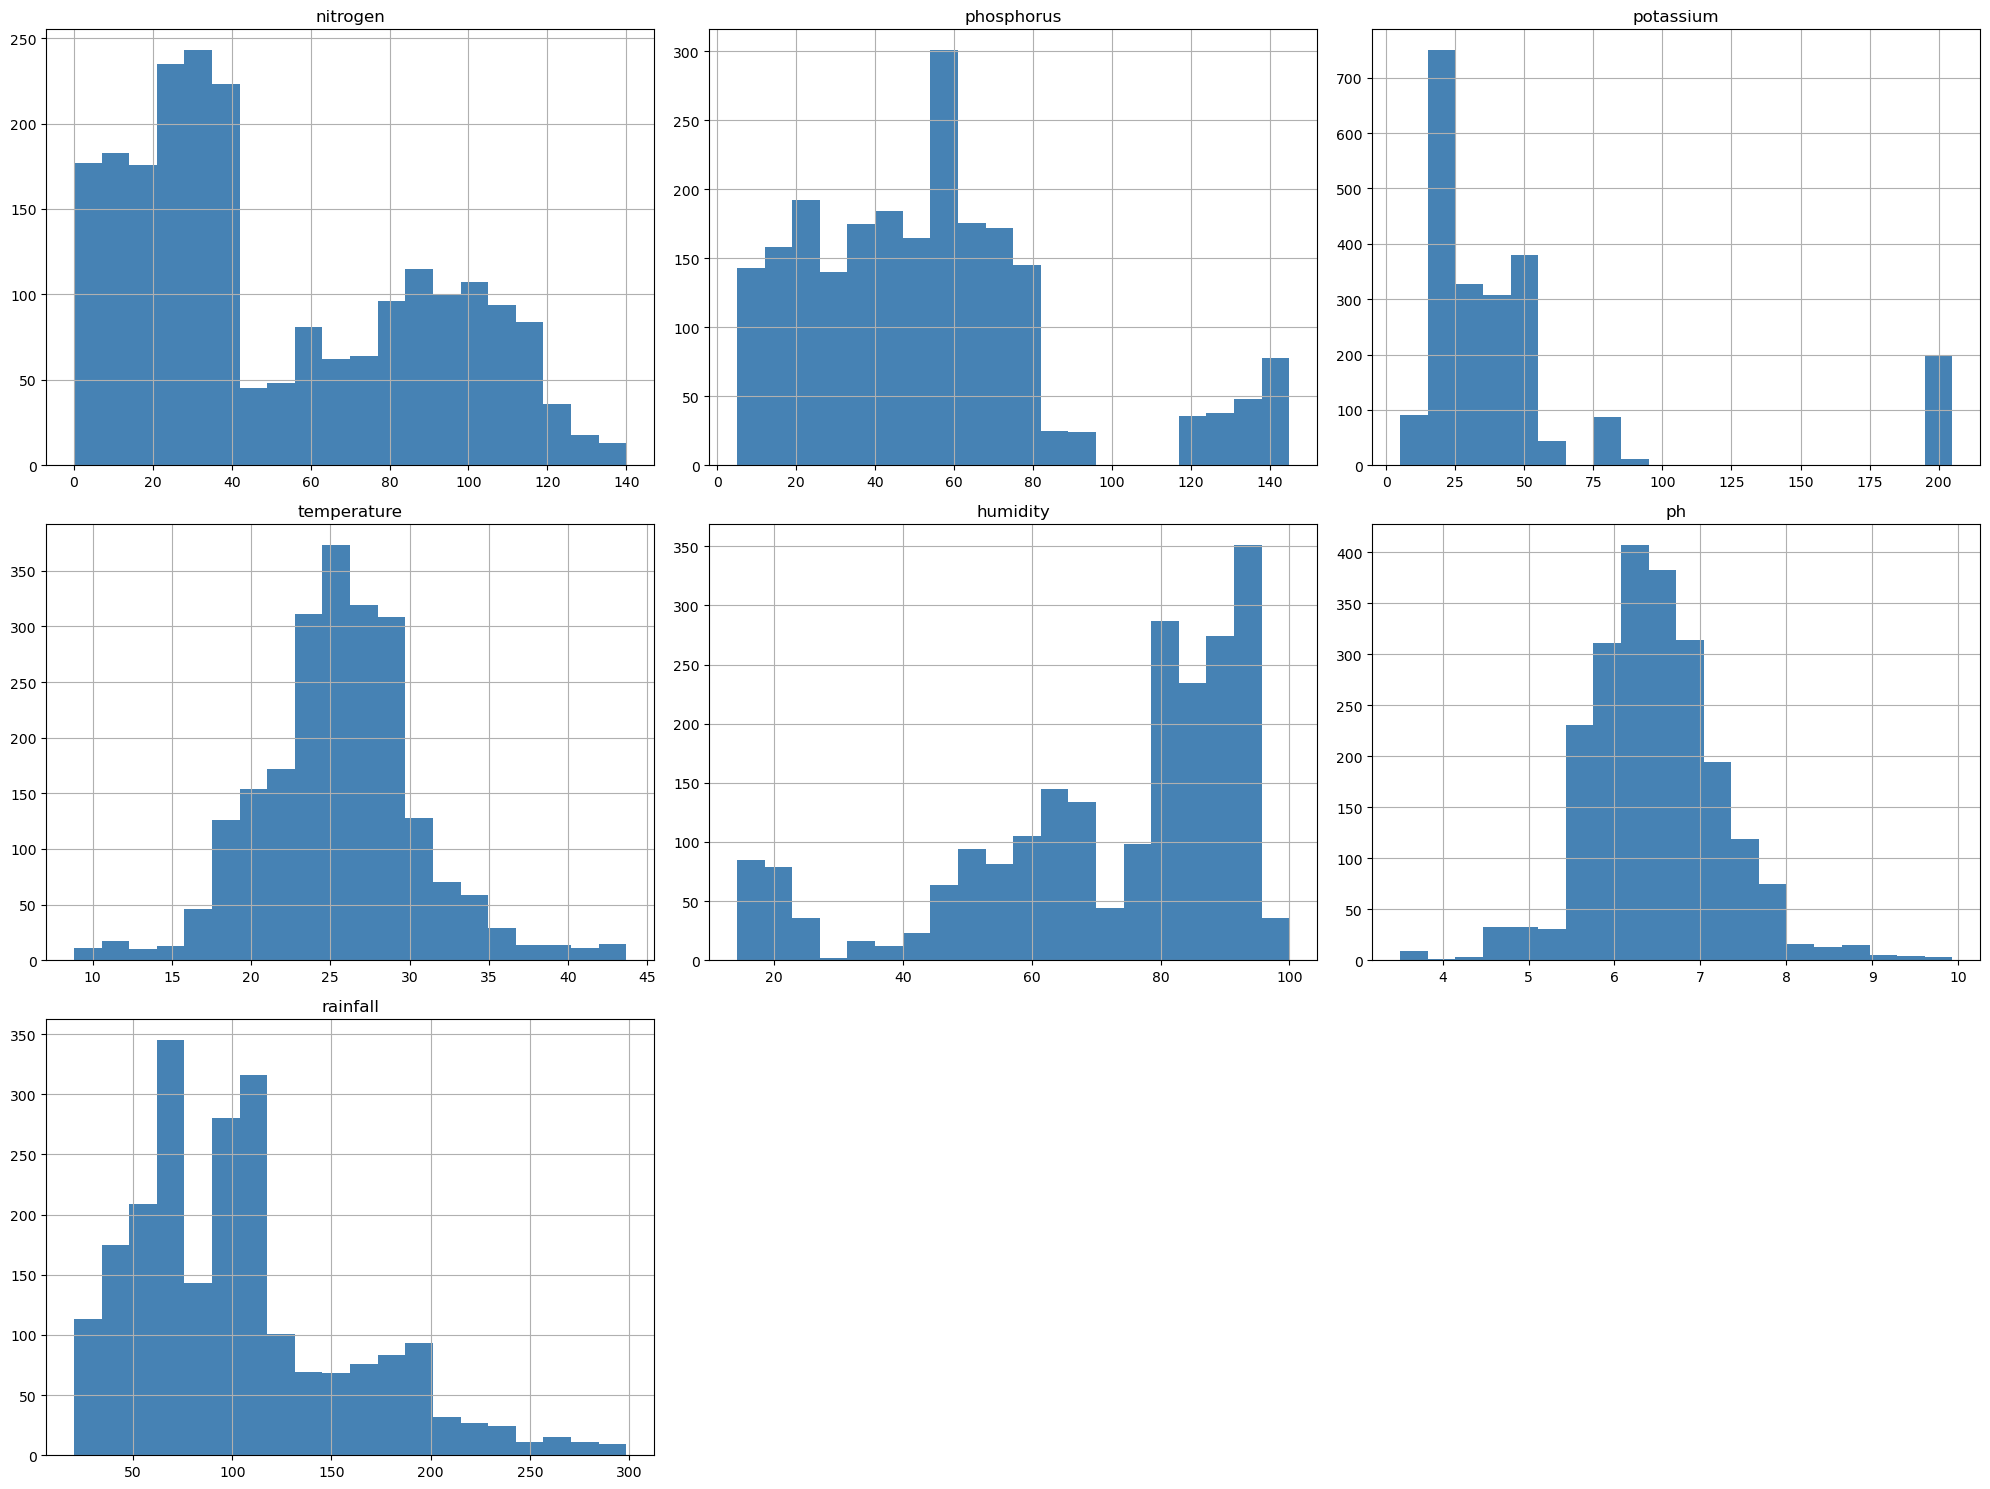

In [17]:
eda_data.hist(bins=20, figsize=(20,15), color='steelblue')
plt.tight_layout()
plt.show()

Next correlation heatmap is plotted to observe relationships between features. Here it can be observed that most features have little to no correlation between each other - except for potassium and phosphorus. To explore further this relationship is plotted.

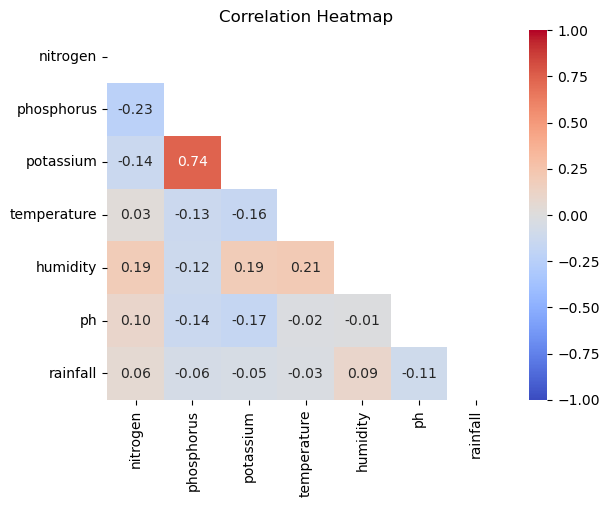

In [19]:
# Get correlation values
features = list(eda_data.columns)[:-1]
corr_matrix = eda_data[features].corr()

# Hide duplicate and diagonal values
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap")
plt.show()

Here it is observed how distinct classes are, with the distribution of points forming rectangles. This suggests that crops are on the whole more sensitive to potassium levels being correct rather than phosphorus. Also, the correlation may be in part due to grapes and apples requiring higher levels of the two minerals than other crops.  

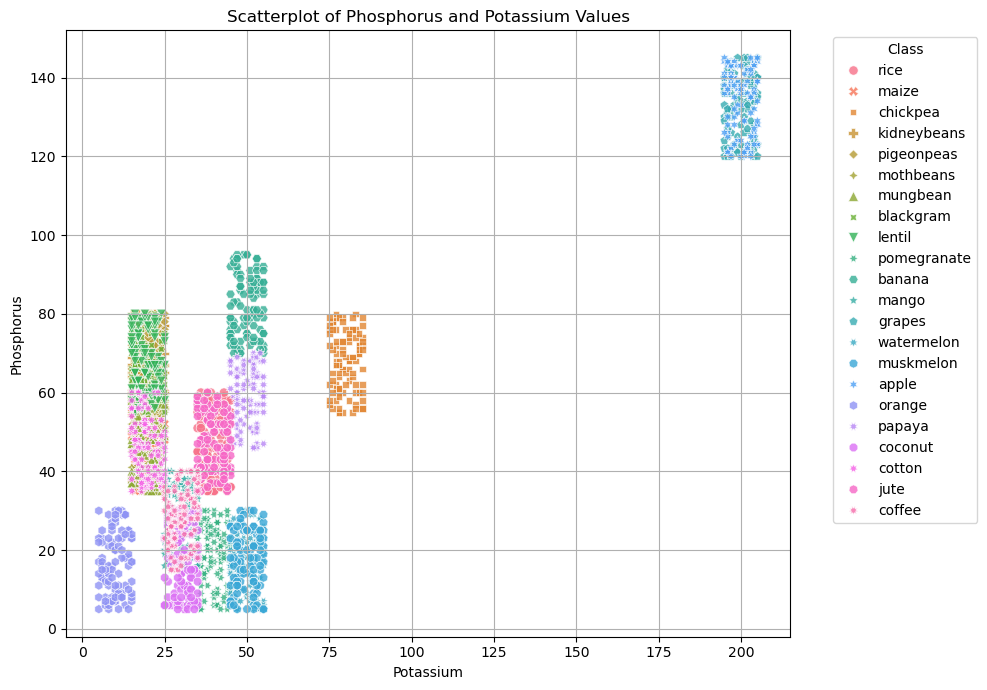

In [21]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=eda_data,
    x='potassium',
    y='phosphorus',
    hue='label',
    style='label',
    s=45,             
    alpha=0.8
)

plt.title('Scatterplot of Phosphorus and Potassium Values')
plt.xlabel('Potassium')
plt.ylabel('Phosphorus')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

The distinct class groupings prompted further exploration of distributions within scatterplots. This, and the need to gain further understanding of the dataset motivated creating a pairplot.

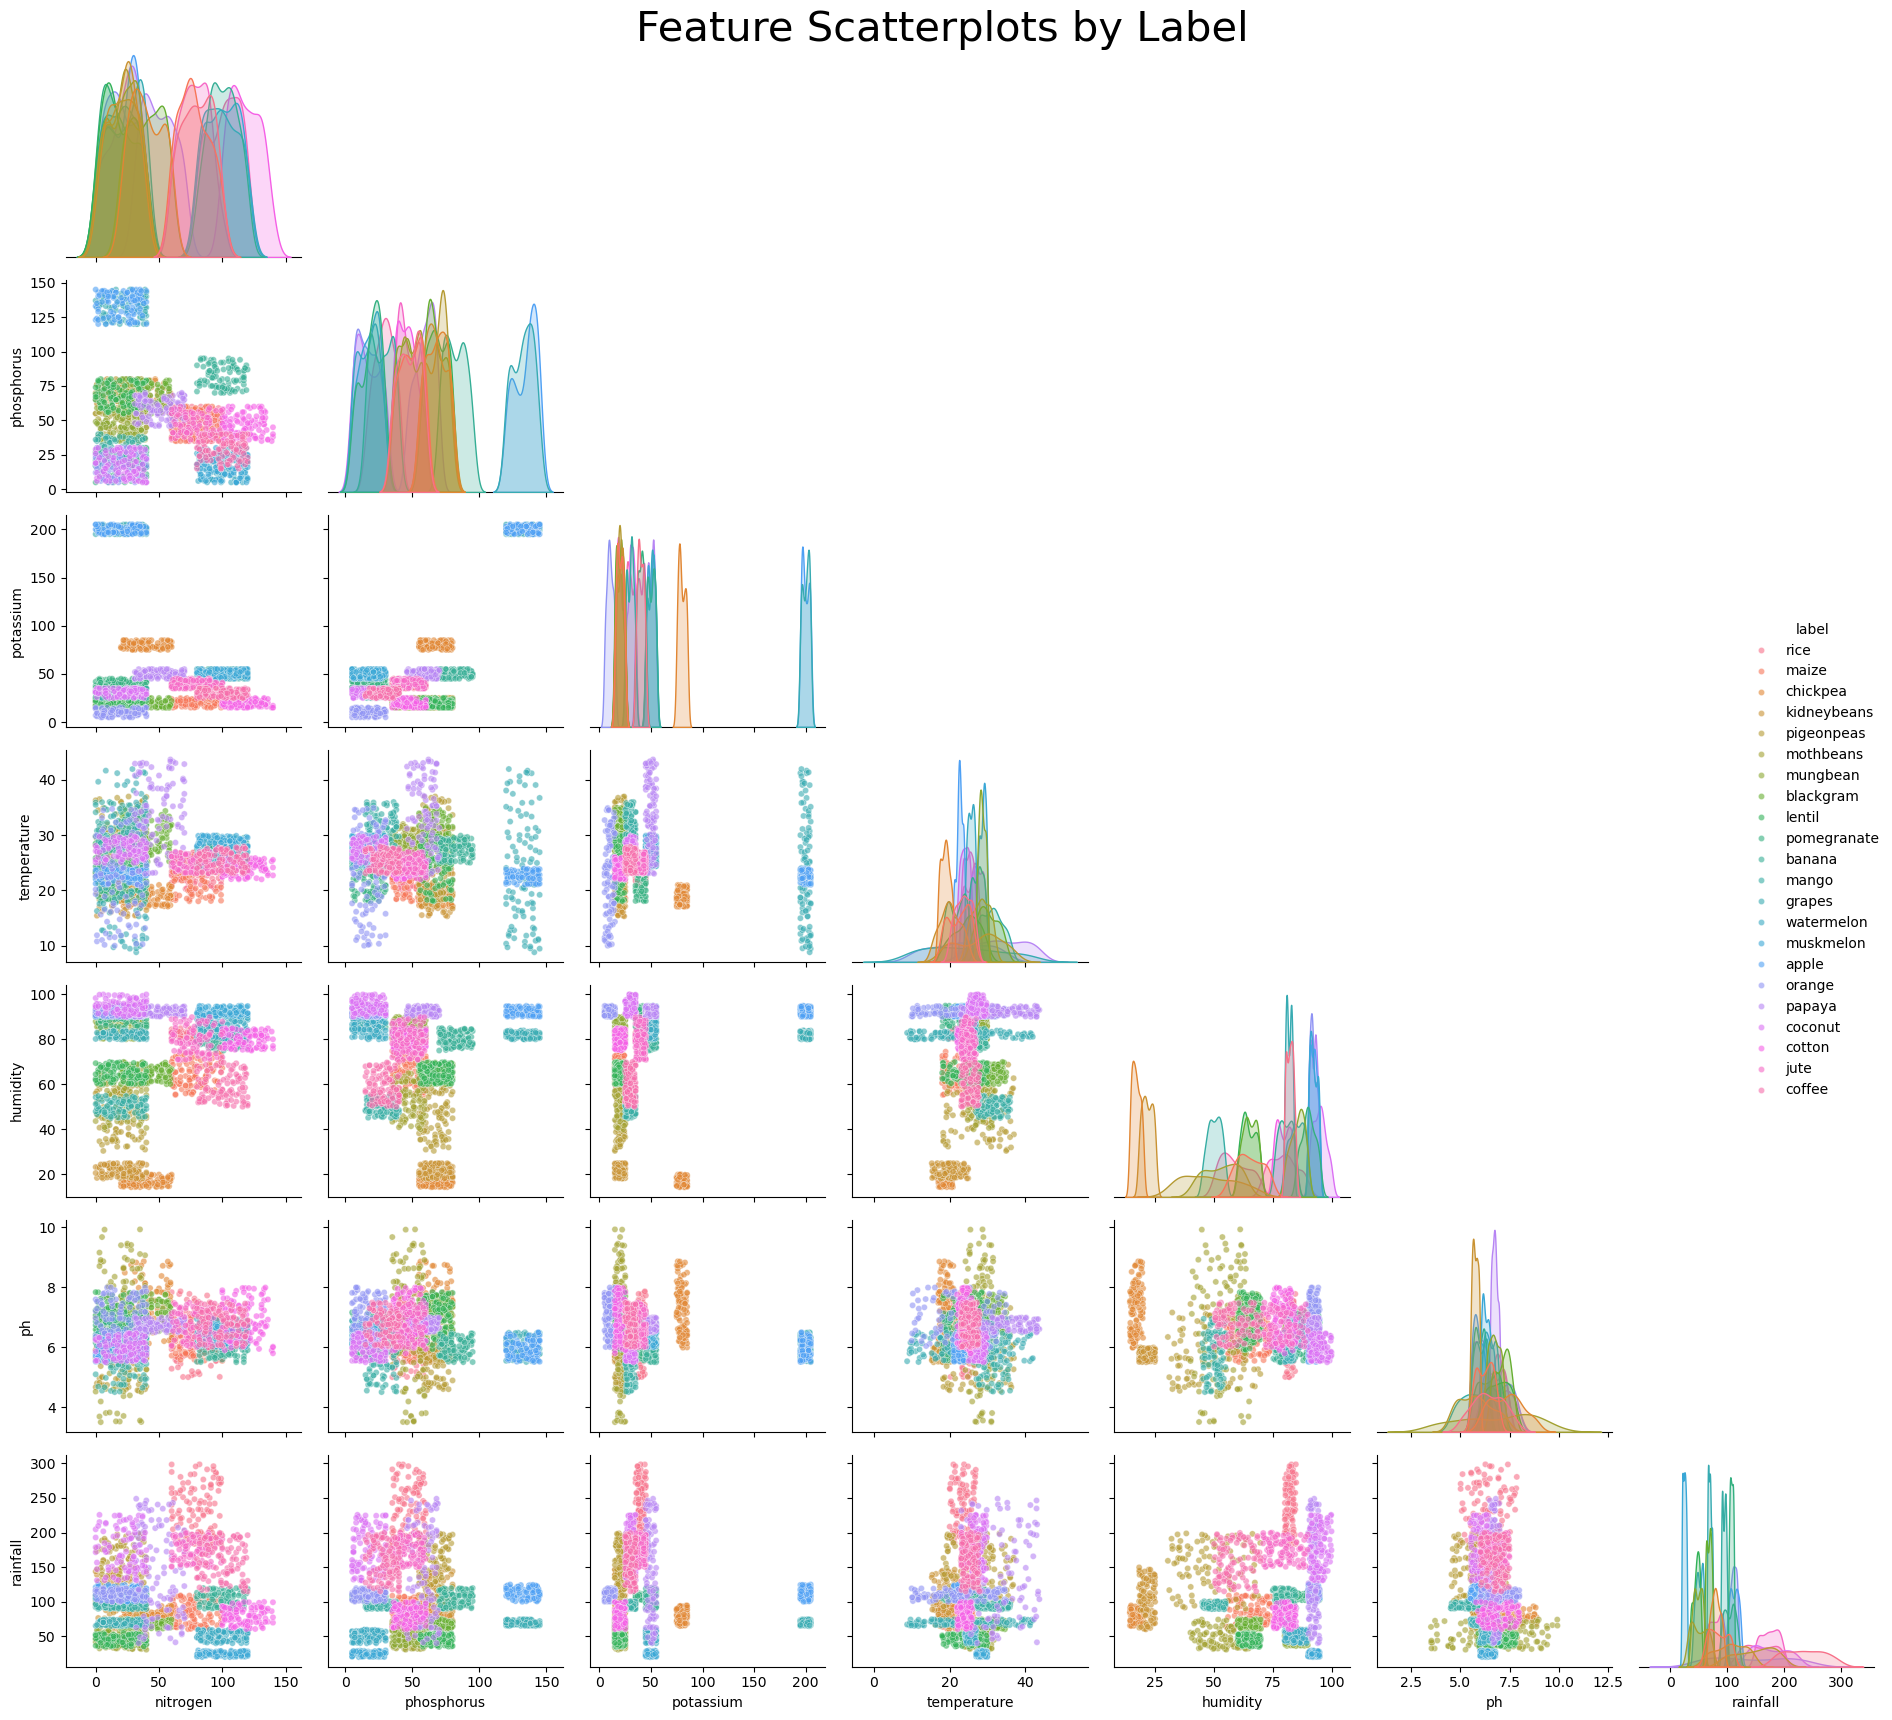

In [23]:
sns.pairplot(eda_data,
             hue='label',
             corner=True,
             plot_kws={'alpha': 0.6, 's': 20})

plt.suptitle('Feature Scatterplots by Label', fontsize=30)
plt.tight_layout()
plt.show()

Simmilar distributions are again observed. The long and thin shape of rectangles suggest that some features may be much more important for classification than others. 

Finally, PCA is attempted to gain 2-D projection of the dataset as a whole for visualisation. Sum of variance on first two PCs was seen to be more than 50% - so projection is deemed valid.

In [25]:
# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(eda_data[features])

# Get variance values from PCA result
var_exp = pca.explained_variance_ratio_
print(f'Variance explained by first two PCs: {sum(var_exp):.3f}')

Variance explained by first two PCs: 0.744


Here again, apples and grapes can be seen to lie further out than the other crops. Tight class groupings are also oberved, staying consistent with previous pairplot.

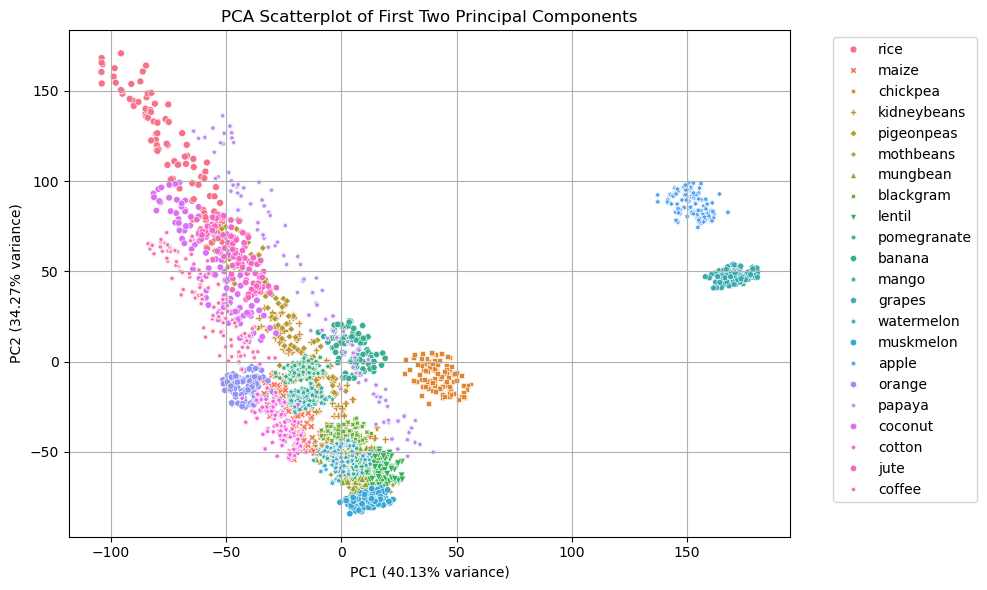

In [27]:
# Get variance values on PCs
pc1_var = var_exp[0] * 100
pc2_var = var_exp[1] * 100

# Create a new DataFrame for plotting
pca_plot = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_plot['label'] = eda_data['label']


# Show scatterplot of PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_plot, x='PC1', y='PC2', hue='label', style='label', s=25)
plt.title('PCA Scatterplot of First Two Principal Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.grid()
plt.tight_layout()
plt.show()

### Outlier Detection and Removal

Outlier detection is approached with caution due to fear of information loss. EDA revealed distribution per class to be non-gaussian. Therefore inter quartile range was used on a per label basis, examining features individually for each label. This was achieved with the use of a nested loop - followed by removal of identified indices from a duplicate copy of the dataset.

In [30]:
class_names = eda_data['label'].unique()
data_clean = eda_data.copy()
outlier_count = 0

# Loop through crop types
for crop in class_names:
    
    # Loop through each feature for given crop
    for feature in features:
        
        # Get feature data for respective crop
        outlier_check_data = eda_data[eda_data['label'] == crop][feature]
        
        # Get quartiles and calculate IQR bounds
        first_quartile = np.percentile(outlier_check_data, 25)
        third_quartile = np.percentile(outlier_check_data, 75)
        iqr = third_quartile - first_quartile
        lower_bound = first_quartile - 1.5 * iqr
        upper_bound = third_quartile + 1.5 * iqr
        
        # Detect outliers
        outliers = outlier_check_data[(outlier_check_data < lower_bound) | (outlier_check_data > upper_bound)]
        outlier_count += len(outliers)

        # Remove the detected outliers
        data_clean = data_clean.drop(index=outliers.index)

# Display outlier removal results
print("Total outliers detected:", outlier_count)
print("Row numbers after cleaning:", data_clean.shape[0])

Total outliers detected: 0
Row numbers after cleaning: 2200


Surprisingly, no outliers were found. Dataset is now ready for machine learning techniques to be applied.

In [32]:
dataset = data_clean.copy()

## Supervised Learning

Target and features are seperated for training/test split. Training set will be used for 5-fold cross validation and testing set will be reserved to be used as unseen validation set. Note also that seperate encoded version of targets is made to aid classification - for visualising model performance the categorical version will be more informative

In [35]:
# Get target column and change it to it numpy ndarray for classification
y_categorical = dataset['label']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_categorical)

# Unlabeled dataset
X = dataset[features]

# Make train/test split - note cross validation will be used on training set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=seed, stratify=y_encoded # Maintain class balance
)

### Logistic Regression

Logistic regression is performed first as its quick and highly interpetable. More powerful, but less interpeetable models will be explored later. After initial regression model and evaluation, regularisation will be used to reduce effects of overfitting as well as to observe model coefficients.

#### Initial model

Initial model performed well during cross validation with almost perfect classification - note high F-1 score and low spread

In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=seed) # 5-fold cross validation is used

# Simple Logistic Regression with data standardisation
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000))
])

# Perform cross validation
cv_performance = cross_val_score(lr_pipe, X_train, y_train, cv=cv, scoring='f1_macro')
print(f'F-1 score mean: {cv_performance.mean():.3f}')
print(f'F-1 score spread: {cv_performance.std():.3f}')

F-1 score mean: 0.964
F-1 score spread: 0.017


Following cross validation, model is fitted on whole training data and more detailed performance evaluation is extracted from unseen validation set. High performance here again is good but could be an indicator of overfitting. Regularisation will be attempted next to reduce chances of overfitting.

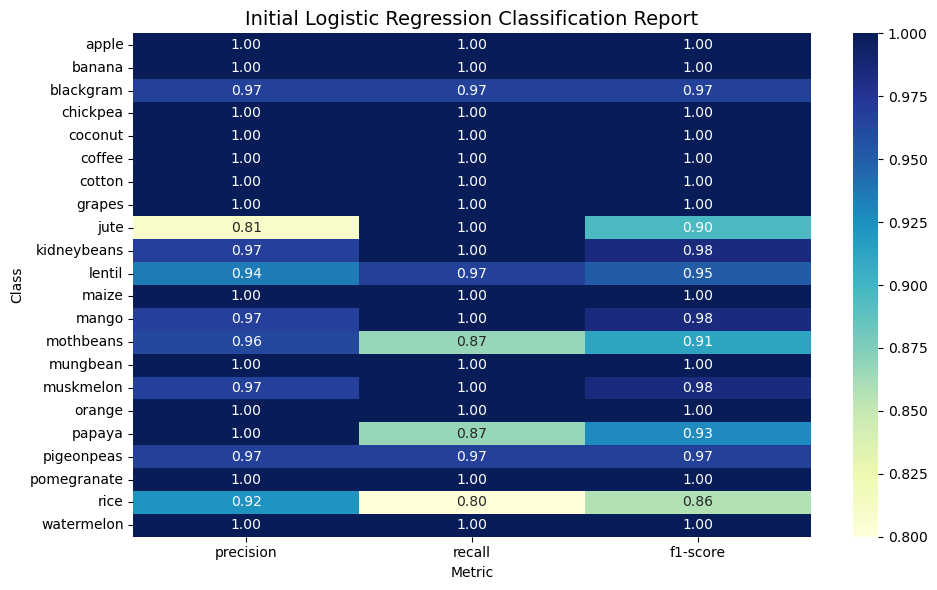

In [42]:
# Following cross validation, fit model on training data
lr_pipe.fit(X_train, y_train)

# Get predictions from unseen validation set
y_pred_lr = lr_pipe.predict(X_test)

# Get classification report
lr_report = classification_report(y_test, y_pred_lr, target_names=encoder.classes_,output_dict=True)

# Convert to DataFrame for plotting
lr_report_data = pd.DataFrame(lr_report).transpose()
lr_report_data = lr_report_data.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Display model metrics per label
plt.figure(figsize=(10, 6))
sns.heatmap(lr_report_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Initial Logistic Regression Classification Report", fontsize=14)
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

#### Model Regularisation

For regularisation L1, L2 and Elastic Net are all considered. Hyperparameter tuning is performed for each technique on penalty coefficient and also for alpha value on Elastic Net. Best performing regularisation technique (in this case Elastic Net) is picked for further evaluation.

In [45]:
# Define hyperparameter tuning grid
lr_param_grid = [
    {'lr__penalty': ['l1'], 'lr__C': [0.01, 0.1, 1, 10]}, # Note here that logreg_C is the inverse of the lambda cost parameter
    {'lr__penalty': ['l2'], 'lr__C': [0.01, 0.1, 1, 10]},
    {'lr__penalty': ['elasticnet'], 'lr__C': [0.01, 0.1, 1, 10], 'lr__l1_ratio': [0.2, 0.4, 0.6, 0.8]} # 0=Ridge and 1=Lasso, therefore these values excluded
]

# Perform hyperparameter tuning on regularisation techniques with cross-validation on training data
grid = GridSearchCV(estimator=lr_pipe,
                    param_grid=lr_param_grid,
                    cv=cv, # recall previously defined 5-fold cross validation
                    scoring='f1_macro',
                    n_jobs=-1) # use all available cpu cores
grid.fit(X_train, y_train)

# Best parameters and score
print("Best regularization method and hyperparameters:")
print(grid.best_params_)
print(f"Best CV F1 Macro Score: {grid.best_score_:.4f}")


Best regularization method and hyperparameters:
{'lr__C': 10, 'lr__l1_ratio': 0.8, 'lr__penalty': 'elasticnet'}
Best CV F1 Macro Score: 0.9763


Following tuning best model is extracted and used to test on unseen validation set. Note improved performance compared to intial model.

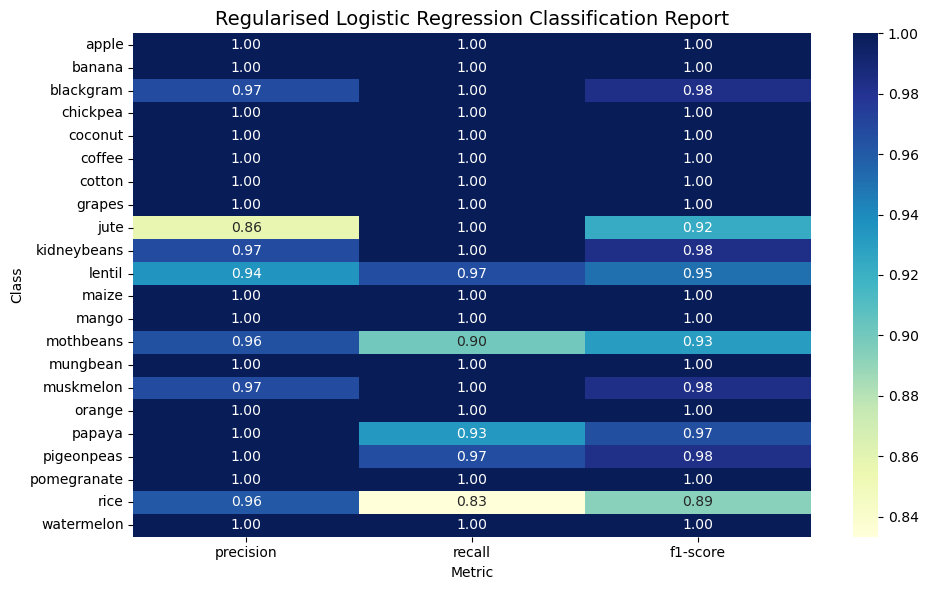

In [47]:
tuned_logistic_regressor = grid.best_estimator_ # best model stored seperately, will be useful later
y_pred_rlr = tuned_logistic_regressor.predict(X_test)

# Note code below is copied from above but with variable names changed
# Get classification report
rlr_report = classification_report(y_test, y_pred_rlr, target_names=encoder.classes_,output_dict=True)

# Convert to DataFrame for plotting
rlr_report_data = pd.DataFrame(rlr_report).transpose()
rlr_report_data = rlr_report_data.drop(['accuracy', 'macro avg', 'weighted avg'])

# Display model metrics per label
plt.figure(figsize=(10, 6))
sns.heatmap(rlr_report_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Regularised Logistic Regression Classification Report", fontsize=14)
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

Coefficients are then also extracted and reformatted for use in plotting

In [49]:
# Get tuned and regularised logitic regressor
best_model = grid.best_estimator_
reg_lr_model = best_model.named_steps['lr'] # Get model from pipeline

# Get coefficients and organise them into a dataframe for plotting/analysis
coef_matrix = reg_lr_model.coef_  
coefficients_data = pd.DataFrame(coef_matrix, 
                                 index=encoder.classes_, # Get origional class names
                                 columns=X.columns)

A heatmap is used to compare model coefficients across classes and features with special attention payed to coefficients shrunk to zero. The sum of absoloute coefficient values is also calculated for features (columns) for insight into feature importance. Here it can be noted that temperature and ph seem to play a much smaller role in classification than other coefficients.

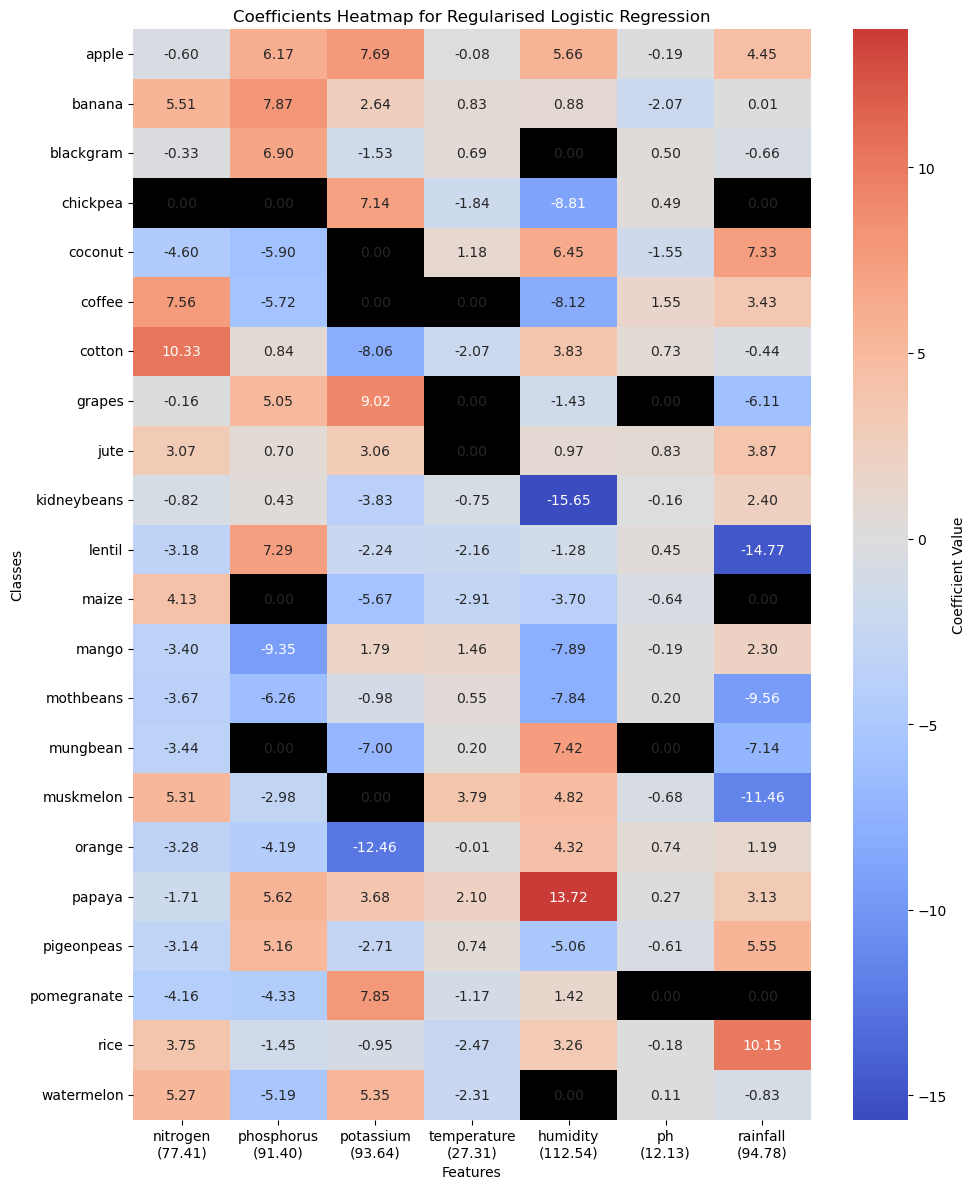

In [51]:
# Get boolean dataframe for where coefficients were shrunck to zero
zero_mask = (coefficients_data == 0)

# Get sum of absoloute values for coefficients by column
abs_coef_cols = coefficients_data.abs().sum(axis=0)

# Create labels with coefficients sums appended
col_labels = [f"{feat}\n({count:.2f})" for feat, count in zip(coefficients_data.columns, abs_coef_cols)]

plt.figure(figsize=(10, 12))

# Plot heatmap
ax = sns.heatmap(
    coefficients_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Coefficient Value'}
)

# Overlay black squares on zeros
for i in range(coefficients_data.shape[0]):
    for j in range(coefficients_data.shape[1]):
        if zero_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', lw=0))

ax.set_xticklabels(col_labels)
plt.title("Coefficients Heatmap for Regularised Logistic Regression")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

### Further Supervised Learning

Following logistic regression other learning models are also explored. This is done to observe how alternative methods perform on the dataset, lending to alternative ways of classifying as well as to gaining insight into underlying relations within the dataset from model performance.

In [54]:
# Models are defined within a collective dictionary structure, together with parameters for tuning.
# Note pipeline only used for models sensitive to data standardisation
models = { 
# ---------------------------------------- #
    'RFC': 
    (RandomForestClassifier(), 
    
     # RFC hyparameters:
     {'n_estimators': [10, 50, 100, 150, 200],
      'min_samples_split': [2, 3, 5, 7, 9],
      'min_samples_leaf': [1, 3, 5, 7, 9],
      'criterion': ['gini', 'entropy','log_loss'],
      'max_depth': [5, 10, 20]}), #  'None' excluded as can be more prone to overfitting
# ---------------------------------------- #
    'SVC':
    (Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())]),
     
     # SVC hyparameters 
     {'svc__C': [0.1, 0.5, 1, 5, 10],
      'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
      'svc__kernel': ['linear', 'poly', 'rbf']}),
# ---------------------------------------- #
    'NB':
    (Pipeline([
        ('scaler', StandardScaler()),
        ('nb', GaussianNB())]),
     
     # Naive Bayes has no hyperparameters so dictionary here is empty
     {}),
# ---------------------------------------- #
    'KNN':
    (Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]), 
     
     # KNN hyparameters
     {'knn__n_neighbors': [3, 5, 7]}),
# ---------------------------------------- #
    'XGBoost': 
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), 
     
     # XGBoost hyparameters
     {'n_estimators': [100, 150, 200],
      'max_depth': [3, 6],
      'learning_rate': [0.1, 0.01]}),
# ---------------------------------------- #
    'GradientBoosting': 
    (GradientBoostingClassifier(),
     
     # GBoost hyparameters (same as XGB)
     {'n_estimators': [100, 150, 200],
      'max_depth': [3, 6],
      'learning_rate': [0.1, 0.01]})
# ---------------------------------------- #
}

**Warning:** The cell below takes a while to execute, this is where nested cross-validation/hyperparamater tuning is performed for models/parameters defined above

In [ ]:
# Dictionary for storing all tuned models, alongisde model metrics - note logistic regression has already been tuned
tuned_models = {
    'LR':
    {'model': tuned_logistic_regressor,
     'report': lr_report}
}

# Loop through the dictionary from above for tuning across defined models/paramaters
for name, (model, parameters) in models.items():
    print(f"Training {name}")

    # Perform nested cross-validated hyperparameter tuning
    tuned_model = GridSearchCV(model,
                               param_grid=parameters,
                               cv=cv, # Recall previously defined 5-fold cross validation
                               scoring='f1_macro',
                               n_jobs=-1) # Use all available cpu cores
    
    tuned_model.fit(X_train, y_train)

    # Display tuned hyperparameters
    print(f"Best params for {name}: {tuned_model.best_params_}")

    # Get model metrics from unseen validation set
    y_pred = tuned_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

    # Add tuned model alongside performance metrics for model comparison
    tuned_models[name] = {
        'model': tuned_model.best_estimator_,
        'report': report}

Training RFC
Best params for RFC: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training SVC
Best params for SVC: {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Training NB
Best params for NB: {}
Training KNN
Best params for KNN: {'knn__n_neighbors': 3}
Training XGBoost


C:\Users\danie\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:43:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Training GradientBoosting


Below is a quick comparison of F1 scores between the tuned models. Note again the high performance across all models

In [ ]:
for model_name, result in tuned_models.items():
    f1 = result['report']['macro avg']['f1-score']
    print(f"F1 Score for {model_name} : {f1:.4f}")

In [ ]:
metrics = []
model_names = []

# Extract scores from classification reports
for model_name, result in tuned_models.items():
    report = tuned_models[model_name]['report']
    metrics.append([
        report['macro avg']['precision'],
        report['macro avg']['recall'],
        report['macro avg']['f1-score']
    ])
    model_names.append(model_name)

# Create DataFrame for metrics
metrics_data = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1'], index=model_names)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Model Metrics Comparison')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()



### Model Robustness Testing

In [ ]:
# Function for adding noise
def inject_noise(X, spread):
    '''Given a dataset and a parameter for spread,
    returns the same dataset but with gaussian noise'''
    
    X_noisy = X.copy()
    noise = np.random.normal(loc=0.0,        # The mean of the generated normal dsitribution
                             scale=spread,  # The standard dev of distribution - controlls spread
                             size=X.shape)   # Get same size as dataset
    return X_noisy + noise

# Function for adding null values
def inject_missing(X, missing_rate):
    '''Given a dataset and a float between 0 and 1,
    returns the same dataset but with aproximately the respective number of random null values.'''
    
    X_missing = X.copy()

    # Generate a matrix of random floats then return a boolean mask with prevailance of truth values roughly dictated 
    # by the missingness rate
    mask = np.random.rand(*X_missing.shape) < missing_rate

    # Change respuctive values to null
    X_missing[mask] = np.nan
    return pd.DataFrame(X_missing, columns=X.columns)


# Strategies for dealing with missing values
imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'knn': KNNImputer()
}

# Values to try for noise and null injection
noise_rates = [0.01, 0.1, 0.3, 0.5, 1]
null_rates = [0.05, 0.1, 0.2]

results = []

# Loop through all noise/null injection values
for noise_rate in noise_rates:
    for null_rate in null_rates:
        
        # Get noisy/null dataset
        X_messy = inject_missing(inject_noise(X_test, noise_rate), null_rate)

        # Loop through imputation strategies and assess model performance for all
        for strategy_name, imputer in imputers.items():

            # Using respective imputation strategy, fill null values on X_messy and save result in new dataframe
            X_imputed = pd.DataFrame(imputer.fit_transform(X_messy),
                                     columns=X_messy.columns,
                                     index=X_messy.index)

            # Loop through the tuned models 
            for model_name, model_report in tuned_models.items():
                model = model_report['model']

                # Perform evaluation using imputed dataset
                y_pred = model.predict(X_imputed)
                score = f1_score(y_test, y_pred, average='macro')
                results.append({
                    'model': model_name,
                    'noise': noise_rate,
                    'missing': null_rate,
                    'imputer': strategy_name,
                    'f1_macro': score
                })

In [ ]:
# Reformat data for plotting
results_long = pd.DataFrame(results).pivot_table(
    index='model',
    columns='imputer',
    values='f1_macro',
    aggfunc='mean'
)

# Plot model metrics by imputer technique
plt.figure(figsize=(10, 6))
sns.heatmap(results_long, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Mean F1 Score by Model and Imputer')
plt.ylabel('Model')
plt.xlabel('Imputer')
plt.tight_layout()
plt.show()

Following avareged F1 scores by imputer, F1 scores were also examined to see how they change with increase in noise/missingness rates.

In [ ]:
results_data = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.lineplot(results_data, x='noise', y='f1_macro', hue='model', marker='o',errorbar=None)
plt.title('F1 Scores Across Noise Levels')
plt.ylabel('F1 Score')
plt.xlabel('Noise Level')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
results_data_knn = results_data[results_data['imputer'] == 'knn']

plt.figure(figsize=(10, 6))
sns.lineplot(results_data_knn, x='missing', y='f1_macro', hue='model', marker='o',errorbar=None)
plt.title('F1 Scores Across Missingness Levels')
plt.ylabel('F1 Score')
plt.xlabel('Missingness Level')
plt.grid()
plt.tight_layout()
plt.show()

## Data Simulation

Bootstrapping will be performed to simulate further model coefficients. 2000 Samples were used with evaluation on out-of-bag data to confirm model/coefficient reliability.

In [ ]:
# Set up
n_iterations = 2000
coef_list = []
f1_scores = []

# Loop: bootstrap sampling and model fitting
for i in tqdm(range(n_iterations), desc="Bootstrapping logistic regressions"):
   
    # Get bootstrap sample - note: simple train/test split used instead of cross validation due to computational cost.
    #                              Also, with high sample count results from simple split become significant/trustworthy
    X_resampled, y_resampled = resample(X_train, y_train, n_samples=X_train.shape[0], random_state=i) # Changing but controlled random state is essential
    
    # Get leftover data for evaluation
    leftover_pos = X_train.index.difference(X_resampled.index)
    X_boot_test = X_train.loc[leftover_pos]
    y_boot_test = encoder.fit_transform(dataset.loc[leftover_pos]['label'])
    
    # Make LR model pipeline
    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
    )
    pipe.fit(X_resampled, y_resampled)

    # Extract fitted model and coefficients
    logreg = pipe.named_steps['logisticregression']
    coefs = logreg.coef_  

    # Evaluate unsampled data
    y_boot_pred = pipe.predict(X_boot_test)
    f1 = f1_score(y_boot_test, y_boot_pred, average='macro')
    f1_scores.append(f1)
    
    # Flatten and store with index
    coef_list.append(coefs.flatten())

Coefiicents are reformatted into a dataframe for clustering

In [ ]:
# Convert to DataFrame for clustering
simulated_coefs_data = pd.DataFrame(
    np.array(coef_list),
    columns=[f'{class_}_{feature}' for class_ in encoder.classes_ for feature in X_train.columns]
)

F-1 scores are plotted. See here high performance, low spread and almost perfect normal distribution. The strength of the distribution indicates changes in performance are down to chance - not any underlying relationships in the dataset which were missed by the model.

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(f1_scores, bins=11, kde=True, color='steelblue')
plt.title("Distribution of F1 Scores for Bootstrapped Models")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

## Clustering

Hierarchical clustering will be used to cluster coefficents. This method was chsoen as it gives a good visual on how classes cluster from the lowest level to finally the whole dataset.

In [ ]:
# Split column names to extract class and feature
simulated_coefs_long = simulated_coefs_data.copy()
simulated_coefs_long.columns = pd.MultiIndex.from_tuples(
    [col.split("_") for col in simulated_coefs_long.columns],
    names=["Class", "Feature"]
)

# Average across bootstraps
avg_by_class_feat = simulated_coefs_long.mean(axis=0).unstack(level=1) 

# Note data transformation here was assisted by OpenAI’s ChatGPT

In [ ]:
# Perform hierarchical clustering
avg_by_class_feat.index = class_names  
linkage_matrix = linkage(avg_by_class_feat, method='ward')

# Display dendogram of clustering results
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=avg_by_class_feat.index)
plt.title("Hierarchical Clustering on Simulated Coefficients")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()
